# Prototyping

Creates a neural network which evaluates a time series and produce a set of predicted values for the time series
Predicted values may be used in a policy to make a trade. This policy may be modeled by simple multiple regression or a neural network.

## Data
Test data is taken as most recent to avoid lookahead bias. Train data is split into a validation and training set during fitting.


## TODO
- Convert feature percentages to stdev
- Adding VIX as a signal
- Adding High/Low as signals
- Multiple securities/ aggregate samples
- Policy network
- Regularization (l2)
- Dilated convolution

In [93]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow import keras
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import pandas_datareader as pdr
from datetime import datetime


NUM_INPUT_NEURONS = 64
NUM_OUTPUT_NEURONS = 1
DAY_OFFSET = 5

def from_network(symbol):
    return pdr.get_data_yahoo(symbols=symbol, start=datetime(1900, 1, 1))

def from_file(symbol):
    dataset_path = keras.utils.get_file("{}.csv".format(symbol), "http://localhost:8000/data/daily/{}.csv".format(symbol))
    column_names = ['Date','Open','High','Low','Close','Adj Close','Volume'] 
    return pd.read_csv(dataset_path, 
                              names=column_names, 
                              dtype={'Close': np.float64,'Open': np.float64,'High': np.float64,'Adj Close': np.float64, 'Volume': np.float64},
                              header=0,
                              na_values = "?", 
                              comment='\t',
                              sep=",",
                              skipinitialspace=True)


# Create features (only close price for now)
def convert_to_percentage(old, new):
    return (old - new) / old

def convert_labels_to_category(labels): 
    # Simplification - If positive return, 1, else 0
    # return map(lambda arr: 1 if arr[0] > 1 else 0, labels)
    # rounding simpliciation
    return map(lambda arr: map(lambda val: round(val,4),arr), labels)

def convert_to_train(raw_dataset, offset=5):
    dataset = raw_dataset.copy()
    features = []
    labels = []
    for i in range(offset, len(dataset) - NUM_INPUT_NEURONS):

        feature_dataset = dataset[i:i+NUM_INPUT_NEURONS].copy()
        latest_close = feature_dataset['Close'].iloc[0]
        
        features.append(
            feature_dataset['Close']
                .map(lambda current: convert_to_percentage(latest_close, current))
                .tolist()
        )
        labels.append([
            dataset['Close'].iloc[i-1] / latest_close, # 1 day trade
#             dataset['Close'].iloc[i-2] / latest_close, # 2 day trade
#             dataset['Close'].iloc[i-3] / latest_close, # 3 day trade
#             dataset['Close'].iloc[i-4] / latest_close, # 4 day trade
#             dataset['Close'].iloc[i-5] / latest_close, # 5 day trade
        ])
        
    # Without converting labels the precision is hard to determine accuracy. 
    # Rather than crude 0/1, maybe this can be more sophisticated
    labels = convert_labels_to_category(labels)
    
    return [features,labels]
def split_data(symbol):
    fetched = from_network(symbol).sort_values(by=['Date'],ascending=False)
    converted = convert_to_train(fetched)
    features = converted[0]
    labels = converted[1]
    training = [ # since we decide a model, use all data for training
        features[1:],
        labels[1:]
    ]
    validation = [
        features[5:1000],
        labels[5:1000]
    ]
    prediction = [
        features[:5],
        labels[:5],
    ]
    
    return {
        'symbol': symbol,
        'prediction': prediction,
        'validation': validation,
        'training': training,
    }


In [2]:

def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, input_shape=[NUM_INPUT_NEURONS]),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(48, activation=tf.nn.relu),
    layers.Dense(36, activation=tf.nn.relu),
    layers.Dense(24, activation=tf.nn.relu),
    layers.Dense(12, activation=tf.nn.relu),

      
#     layers.Dense(64, kernel_regularizer=keras.regularizers.l1_l2(l1=0.000001, l2=0.000001), activation=tf.nn.relu),
#     layers.Dense(48, kernel_regularizer=keras.regularizers.l1_l2(l1=0.000001, l2=0.000001), activation=tf.nn.relu),
#     layers.Dense(36, kernel_regularizer=keras.regularizers.l1_l2(l1=0.000001, l2=0.000001), activation=tf.nn.relu),
#     layers.Dense(24, kernel_regularizer=keras.regularizers.l1_l2(l1=0.000001, l2=0.000001), activation=tf.nn.relu),
#     layers.Dense(12, kernel_regularizer=keras.regularizers.l1_l2(l1=0.000001, l2=0.000001), activation=tf.nn.relu),
    layers.Dense(NUM_OUTPUT_NEURONS)
  ])

  model.compile(loss='mean_squared_logarithmic_error',
                optimizer='sgd',
#                 metrics=[
#                     'mae',
#                 ]
               )
  return model

tensorboard = keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0,
                          write_graph=True, write_images=False)

model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 48)                3120      
_________________________________________________________________
dense_3 (Dense)              (None, 36)                1764      
_________________________________________________________________
dense_4 (Dense)              (None, 24)                888       
_________________________________________________________________
dense_5 (Dense)              (None, 12)                300       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 13        
Total para

In [73]:

prepped_data = map(split_data, [
    'QQQ',
    'SPY',
    'IWM',
    'XLK',
    'XLF',
    'XLE',
    'XLP',
    'XLV',
    'XLY',
    'XLI',
    'XLU',
])


In [74]:

for i in range(len(prepped_data)):
    print prepped_data[i]['symbol']
    
def combine_all(accum, prep):
    
    print len(accum['training'][0])
    return {   
        'prediction':[
            accum['prediction'][0] + prep['prediction'][0],
            accum['prediction'][1] + prep['prediction'][1],
        ],
        'validation':[
            accum['validation'][0] + prep['validation'][0],
            accum['validation'][1] + prep['validation'][1],
        ],
        'training':[
            accum['training'][0] + prep['training'][0],
            accum['training'][1] + prep['training'][1],
        ],
    }
combined = reduce(combine_all, prepped_data,{
    'prediction':[[],[]],
    'validation':[[],[]],
    'training':[[],[]],
})


QQQ
SPY
IWM
XLK
XLF
XLE
XLP
XLV
XLY
XLI
XLU
0
4943
11428
16063
21058
26053
31048
36043
41038
46033
51028


In [6]:

#init = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
len(combined['training'][0])

55979

In [7]:
#len(converted_feature_set[0][0])
print len(combined['training'][0])
train_data = np.array(combined['training'][0])
train_labels = np.array(combined['training'][1])

print len(combined['validation'][0])
test_data = np.array(combined['validation'][0])
test_labels = np.array(combined['validation'][1])

print len(combined['prediction'][0])
prediction_data = np.array(combined['prediction'][0])
prediction_labels = np.array(combined['prediction'][1])


55979
10945
55


In [8]:
print train_data
print train_labels

[[ 0.          0.01180743  0.0181653  ... -0.03578567 -0.00115048
  -0.04916749]
 [ 0.          0.00643384  0.00772055 ... -0.01311274 -0.06170348
  -0.06562504]
 [ 0.          0.00129504 -0.01911814 ... -0.06857854 -0.0725255
  -0.06703676]
 ...
 [ 0.         -0.01635514 -0.02161122 ... -0.13434394 -0.14368973
  -0.12499815]
 [ 0.         -0.0051715  -0.0183908  ... -0.12528553 -0.10689473
  -0.11264368]
 [ 0.         -0.01315129 -0.01658001 ... -0.10119987 -0.10691924
  -0.08690688]]
[[0.9876]
 [1.0119]
 [1.0065]
 ...
 [0.9977]
 [0.9839]
 [0.9949]]


In [9]:
model.fit(
    train_data, train_labels,
    epochs=5, validation_split = 0.005, verbose=1,
    callbacks=[tensorboard]
)

history = model.fit(
    train_data, train_labels,
    epochs=200, validation_split = 0.005, verbose=1,
    callbacks=[tensorboard]
)



Train on 55699 samples, validate on 280 samples
Epoch 1/5
55699/55699 [==============================] - 3s 49us/step - loss: 0.0103 - val_loss: 4.9644e-05
Epoch 2/5
55699/55699 [==============================] - 2s 45us/step - loss: 5.8784e-05 - val_loss: 4.8547e-05
Epoch 3/5
55699/55699 [==============================] - 3s 45us/step - loss: 5.7285e-05 - val_loss: 4.7423e-05
Epoch 4/5
55699/55699 [==============================] - 3s 45us/step - loss: 5.6024e-05 - val_loss: 4.6434e-05
Epoch 5/5
55699/55699 [==============================] - 2s 45us/step - loss: 5.5022e-05 - val_loss: 4.5645e-05
Train on 55699 samples, validate on 280 samples
Epoch 1/200
55699/55699 [==============================] - 3s 46us/step - loss: 5.4298e-05 - val_loss: 4.5003e-05
Epoch 2/200
55699/55699 [==============================] - 3s 47us/step - loss: 5.3810e-05 - val_loss: 4.4551e-05
Epoch 3/200
55699/55699 [==============================] - 3s 46us/step - loss: 5.3502e-05 - val_loss: 4.4119e-05
Epoch 

Epoch 137/200
55699/55699 [==============================] - 3s 45us/step - loss: 5.1664e-05 - val_loss: 4.3423e-05
Epoch 138/200
55699/55699 [==============================] - 2s 44us/step - loss: 5.1662e-05 - val_loss: 4.3446e-05
Epoch 139/200
55699/55699 [==============================] - 3s 45us/step - loss: 5.1660e-05 - val_loss: 4.3485e-05
Epoch 140/200
55699/55699 [==============================] - 2s 43us/step - loss: 5.1659e-05 - val_loss: 4.3429e-05
Epoch 141/200
55699/55699 [==============================] - 2s 45us/step - loss: 5.1650e-05 - val_loss: 4.3461e-05.178
Epoch 142/200
55699/55699 [==============================] - 2s 44us/step - loss: 5.1653e-05 - val_loss: 4.3407e-05
Epoch 143/200
55699/55699 [==============================] - 2s 44us/step - loss: 5.1650e-05 - val_loss: 4.3425e-05
Epoch 144/200
55699/55699 [==============================] - 2s 44us/step - loss: 5.1636e-05 - val_loss: 4.3431e-05
Epoch 145/200
55699/55699 [==============================] - 2s 44us

In [10]:

def train_model(model):
    return model.fit(
        train_data, train_labels,
        epochs=200, validation_data=(test_data, test_labels), verbose=1,
        callbacks=[tensorboard]
    )   

model_1 = build_model()
model_2 = build_model()
model_3 = build_model()
model_4 = build_model()
model_5 = build_model()
model_6 = build_model()
model_7 = build_model()
model_8 = build_model()
model_9 = build_model()
model_0 = build_model()

map(train_model, [model_1, model_2, model_3, model_4,model_5,model_6,model_7,model_8,model_9,model_0])

Train on 55979 samples, validate on 10945 samples
Epoch 1/200
55979/55979 [==============================] - 3s 57us/step - loss: 0.0034 - val_loss: 4.7675e-05
Epoch 2/200
55979/55979 [==============================] - 3s 55us/step - loss: 1.0834e-04 - val_loss: 4.3739e-05
Epoch 3/200
55979/55979 [==============================] - 3s 57us/step - loss: 9.4117e-05 - val_loss: 4.1516e-05s - 
Epoch 4/200
55979/55979 [==============================] - 3s 54us/step - loss: 8.6166e-05 - val_loss: 3.9443e-05
Epoch 5/200
55979/55979 [==============================] - 3s 53us/step - loss: 8.1050e-05 - val_loss: 3.8574e-05
Epoch 6/200
55979/55979 [==============================] - 3s 52us/step - loss: 7.7537e-05 - val_loss: 3.7551e-05
Epoch 7/200
55979/55979 [==============================] - 3s 52us/step - loss: 7.4947e-05 - val_loss: 3.6478e-05
Epoch 8/200
55979/55979 [==============================] - 3s 52us/step - loss: 7.2948e-05 - val_loss: 3.5984e-05
Epoch 9/200
55979/55979 [=============

Epoch 142/200
55979/55979 [==============================] - 3s 51us/step - loss: 5.3885e-05 - val_loss: 2.7547e-05
Epoch 143/200
55979/55979 [==============================] - 3s 52us/step - loss: 5.3872e-05 - val_loss: 2.7547e-05
Epoch 144/200
55979/55979 [==============================] - 3s 52us/step - loss: 5.3848e-05 - val_loss: 2.7588e-05
Epoch 145/200
55979/55979 [==============================] - 3s 52us/step - loss: 5.3833e-05 - val_loss: 2.7601e-05
Epoch 146/200
55979/55979 [==============================] - 3s 52us/step - loss: 5.3819e-05 - val_loss: 2.7544e-05
Epoch 147/200
55979/55979 [==============================] - 3s 52us/step - loss: 5.3800e-05 - val_loss: 2.7512e-05
Epoch 148/200
55979/55979 [==============================] - 3s 52us/step - loss: 5.3782e-05 - val_loss: 2.7493e-05
Epoch 149/200
55979/55979 [==============================] - 3s 53us/step - loss: 5.3761e-05 - val_loss: 2.7573e-05
Epoch 150/200
55979/55979 [==============================] - 3s 53us/ste

55979/55979 [==============================] - 3s 50us/step - loss: 5.4135e-05 - val_loss: 2.7514e-05
Epoch 84/200
55979/55979 [==============================] - 3s 50us/step - loss: 5.4085e-05 - val_loss: 2.7453e-05
Epoch 85/200
55979/55979 [==============================] - 3s 49us/step - loss: 5.4060e-05 - val_loss: 2.7408e-05
Epoch 86/200
55979/55979 [==============================] - 3s 49us/step - loss: 5.4040e-05 - val_loss: 2.7394e-05
Epoch 87/200
55979/55979 [==============================] - 3s 48us/step - loss: 5.4014e-05 - val_loss: 2.7402e-05
Epoch 88/200
55979/55979 [==============================] - 3s 48us/step - loss: 5.3982e-05 - val_loss: 2.7376e-05
Epoch 89/200
55979/55979 [==============================] - 3s 47us/step - loss: 5.3970e-05 - val_loss: 2.7398e-05
Epoch 90/200
55979/55979 [==============================] - 3s 49us/step - loss: 5.3929e-05 - val_loss: 2.7347e-05
Epoch 91/200
55979/55979 [==============================] - 3s 49us/step - loss: 5.3892e-05 -

55979/55979 [==============================] - 3s 47us/step - loss: 5.6511e-05 - val_loss: 2.8714e-05
Epoch 24/200
55979/55979 [==============================] - 3s 50us/step - loss: 5.6386e-05 - val_loss: 2.8910e-05
Epoch 25/200
55979/55979 [==============================] - 3s 46us/step - loss: 5.6271e-05 - val_loss: 2.8675e-05
Epoch 26/200
55979/55979 [==============================] - 3s 46us/step - loss: 5.6156e-05 - val_loss: 2.8570e-05
Epoch 27/200
55979/55979 [==============================] - 3s 46us/step - loss: 5.6053e-05 - val_loss: 2.8537e-05
Epoch 28/200
55979/55979 [==============================] - 3s 47us/step - loss: 5.5942e-05 - val_loss: 2.8444e-05
Epoch 29/200
55979/55979 [==============================] - 3s 46us/step - loss: 5.5855e-05 - val_loss: 2.8527e-05
Epoch 30/200
55979/55979 [==============================] - 3s 46us/step - loss: 5.5755e-05 - val_loss: 2.8489e-05
Epoch 31/200
55979/55979 [==============================] - 3s 46us/step - loss: 5.5677e-05 -

55979/55979 [==============================] - 3s 58us/step - loss: 5.2268e-05 - val_loss: 2.7154e-05: 1s 
Epoch 165/200
55979/55979 [==============================] - 3s 59us/step - loss: 5.2253e-05 - val_loss: 2.7175e-05
Epoch 166/200
55979/55979 [==============================] - 3s 51us/step - loss: 5.2236e-05 - val_loss: 2.7145e-05
Epoch 167/200
55979/55979 [==============================] - 3s 53us/step - loss: 5.2230e-05 - val_loss: 2.7151e-05
Epoch 168/200
55979/55979 [==============================] - 3s 55us/step - loss: 5.2222e-05 - val_loss: 2.7137e-05
Epoch 169/200
55979/55979 [==============================] - 3s 57us/step - loss: 5.2199e-05 - val_loss: 2.7136e-05
Epoch 170/200
55979/55979 [==============================] - 3s 54us/step - loss: 5.2198e-05 - val_loss: 2.7152e-05
Epoch 171/200
55979/55979 [==============================] - 3s 57us/step - loss: 5.2187e-05 - val_loss: 2.7126e-05
Epoch 172/200
55979/55979 [==============================] - 3s 53us/step - loss:

55979/55979 [==============================] - 4s 65us/step - loss: 5.2724e-05 - val_loss: 2.7200e-05
Epoch 106/200
55979/55979 [==============================] - 3s 57us/step - loss: 5.2711e-05 - val_loss: 2.7194e-05
Epoch 107/200
55979/55979 [==============================] - 3s 61us/step - loss: 5.2692e-05 - val_loss: 2.7193e-05
Epoch 108/200
55979/55979 [==============================] - 4s 68us/step - loss: 5.2669e-05 - val_loss: 2.7237e-05
Epoch 109/200
55979/55979 [==============================] - 4s 64us/step - loss: 5.2660e-05 - val_loss: 2.7190e-05
Epoch 110/200
55979/55979 [==============================] - 5s 81us/step - loss: 5.2640e-05 - val_loss: 2.7177e-05
Epoch 111/200
55979/55979 [==============================] - 4s 74us/step - loss: 5.2619e-05 - val_loss: 2.7191e-05
Epoch 112/200
55979/55979 [==============================] - 3s 54us/step - loss: 5.2598e-05 - val_loss: 2.7257e-05
Epoch 113/200
55979/55979 [==============================] - 3s 56us/step - loss: 5.25

Epoch 45/200
55979/55979 [==============================] - 4s 71us/step - loss: 5.5472e-05 - val_loss: 2.8612e-05
Epoch 46/200
55979/55979 [==============================] - 4s 75us/step - loss: 5.5405e-05 - val_loss: 2.8561e-05
Epoch 47/200
55979/55979 [==============================] - 4s 74us/step - loss: 5.5319e-05 - val_loss: 2.8556e-05
Epoch 48/200
55979/55979 [==============================] - 3s 58us/step - loss: 5.5263e-05 - val_loss: 2.8497e-05
Epoch 49/200
55979/55979 [==============================] - 3s 51us/step - loss: 5.5198e-05 - val_loss: 2.8470e-05
Epoch 50/200
55979/55979 [==============================] - 3s 52us/step - loss: 5.5139e-05 - val_loss: 2.8446e-05- ETA: 0s
Epoch 51/200
55979/55979 [==============================] - 3s 62us/step - loss: 5.5074e-05 - val_loss: 2.8434e-05
Epoch 52/200
55979/55979 [==============================] - 3s 61us/step - loss: 5.5018e-05 - val_loss: 2.8392e-05
Epoch 53/200
55979/55979 [==============================] - 4s 73us/ste

55979/55979 [==============================] - 3s 51us/step - loss: 5.3043e-05 - val_loss: 2.7496e-05
Epoch 117/200
55979/55979 [==============================] - 3s 54us/step - loss: 5.3023e-05 - val_loss: 2.7521e-05
Epoch 118/200
55979/55979 [==============================] - 3s 51us/step - loss: 5.3014e-05 - val_loss: 2.7486e-05
Epoch 119/200
55979/55979 [==============================] - 3s 51us/step - loss: 5.2994e-05 - val_loss: 2.7472e-05
Epoch 120/200
55979/55979 [==============================] - 3s 51us/step - loss: 5.2981e-05 - val_loss: 2.7466e-05
Epoch 121/200
55979/55979 [==============================] - 3s 52us/step - loss: 5.2964e-05 - val_loss: 2.7461e-05
Epoch 122/200
55979/55979 [==============================] - 3s 55us/step - loss: 5.2941e-05 - val_loss: 2.7505e-05
Epoch 123/200
55979/55979 [==============================] - 3s 53us/step - loss: 5.2932e-05 - val_loss: 2.7511e-05
Epoch 124/200
55979/55979 [==============================] - 3s 51us/step - loss: 5.29

55979/55979 [==============================] - 3s 59us/step - loss: 5.4235e-05 - val_loss: 2.7840e-05
Epoch 57/200
55979/55979 [==============================] - 3s 58us/step - loss: 5.4192e-05 - val_loss: 2.7815e-05
Epoch 58/200
55979/55979 [==============================] - 4s 67us/step - loss: 5.4145e-05 - val_loss: 2.7806e-05
Epoch 59/200
55979/55979 [==============================] - 3s 56us/step - loss: 5.4115e-05 - val_loss: 2.7800e-05
Epoch 60/200
55979/55979 [==============================] - 3s 57us/step - loss: 5.4075e-05 - val_loss: 2.7774e-05
Epoch 61/200
55979/55979 [==============================] - 3s 54us/step - loss: 5.4039e-05 - val_loss: 2.7763e-05
Epoch 62/200
55979/55979 [==============================] - 3s 53us/step - loss: 5.4005e-05 - val_loss: 2.7781e-05
Epoch 63/200
55979/55979 [==============================] - 3s 60us/step - loss: 5.3965e-05 - val_loss: 2.7741e-05
Epoch 64/200
55979/55979 [==============================] - 3s 55us/step - loss: 5.3937e-05 -

Epoch 127/200
55979/55979 [==============================] - 3s 55us/step - loss: 5.2582e-05 - val_loss: 2.7394e-05
Epoch 128/200
55979/55979 [==============================] - 3s 56us/step - loss: 5.2565e-05 - val_loss: 2.7367e-05
Epoch 129/200
55979/55979 [==============================] - 3s 53us/step - loss: 5.2555e-05 - val_loss: 2.7354e-05
Epoch 130/200
55979/55979 [==============================] - 3s 55us/step - loss: 5.2542e-05 - val_loss: 2.7347e-05
Epoch 131/200
55979/55979 [==============================] - 3s 54us/step - loss: 5.2527e-05 - val_loss: 2.7343e-05
Epoch 132/200
55979/55979 [==============================] - 3s 53us/step - loss: 5.2515e-05 - val_loss: 2.7337e-05
Epoch 133/200
55979/55979 [==============================] - 3s 55us/step - loss: 5.2504e-05 - val_loss: 2.7333e-05
Epoch 134/200
55979/55979 [==============================] - 3s 54us/step - loss: 5.2486e-05 - val_loss: 2.7363e-05
Epoch 135/200
55979/55979 [==============================] - 3s 53us/ste

55979/55979 [==============================] - 3s 54us/step - loss: 5.5099e-05 - val_loss: 2.8484e-05
Epoch 69/200
55979/55979 [==============================] - 3s 55us/step - loss: 5.5055e-05 - val_loss: 2.8460e-05
Epoch 70/200
55979/55979 [==============================] - 3s 55us/step - loss: 5.5009e-05 - val_loss: 2.8588e-05
Epoch 71/200
55979/55979 [==============================] - 3s 55us/step - loss: 5.4977e-05 - val_loss: 2.8419e-05
Epoch 72/200
55979/55979 [==============================] - 3s 56us/step - loss: 5.4922e-05 - val_loss: 2.8421e-05
Epoch 73/200
55979/55979 [==============================] - 3s 61us/step - loss: 5.4892e-05 - val_loss: 2.8413e-05
Epoch 74/200
55979/55979 [==============================] - 3s 57us/step - loss: 5.4854e-05 - val_loss: 2.8356e-05
Epoch 75/200
55979/55979 [==============================] - 3s 53us/step - loss: 5.4808e-05 - val_loss: 2.8394e-05
Epoch 76/200
55979/55979 [==============================] - 3s 54us/step - loss: 5.4780e-05 -

55979/55979 [==============================] - 3s 56us/step - loss: 5.3131e-05 - val_loss: 2.7565e-05
Epoch 140/200
55979/55979 [==============================] - 3s 55us/step - loss: 5.3123e-05 - val_loss: 2.7563e-05
Epoch 141/200
55979/55979 [==============================] - 3s 59us/step - loss: 5.3105e-05 - val_loss: 2.7541e-05
Epoch 142/200
55979/55979 [==============================] - 3s 54us/step - loss: 5.3071e-05 - val_loss: 2.7576e-05
Epoch 143/200
55979/55979 [==============================] - 3s 57us/step - loss: 5.3060e-05 - val_loss: 2.7520e-05
Epoch 144/200
55979/55979 [==============================] - 3s 61us/step - loss: 5.3050e-05 - val_loss: 2.7539e-05
Epoch 145/200
55979/55979 [==============================] - 3s 62us/step - loss: 5.3025e-05 - val_loss: 2.7566e-05
Epoch 146/200
55979/55979 [==============================] - 4s 64us/step - loss: 5.3001e-05 - val_loss: 2.7757e-05
Epoch 147/200
55979/55979 [==============================] - 4s 68us/step - loss: 5.29

Epoch 80/200
55979/55979 [==============================] - 3s 54us/step - loss: 5.2623e-05 - val_loss: 2.7196e-05
Epoch 81/200
55979/55979 [==============================] - 3s 54us/step - loss: 5.2613e-05 - val_loss: 2.7152e-05
Epoch 82/200
55979/55979 [==============================] - 3s 57us/step - loss: 5.2597e-05 - val_loss: 2.7192e-05
Epoch 83/200
55979/55979 [==============================] - 3s 59us/step - loss: 5.2585e-05 - val_loss: 2.7161e-05
Epoch 84/200
55979/55979 [==============================] - 3s 61us/step - loss: 5.2571e-05 - val_loss: 2.7142e-05ss: 5.
Epoch 85/200
55979/55979 [==============================] - 3s 61us/step - loss: 5.2571e-05 - val_loss: 2.7140e-05
Epoch 86/200
55979/55979 [==============================] - 3s 58us/step - loss: 5.2559e-05 - val_loss: 2.7138e-05
Epoch 87/200
55979/55979 [==============================] - 3s 55us/step - loss: 5.2547e-05 - val_loss: 2.7177e-05
Epoch 88/200
55979/55979 [==============================] - 3s 53us/step -

Epoch 22/200
55979/55979 [==============================] - 3s 56us/step - loss: 0.4807 - val_loss: 0.4806
Epoch 23/200
55979/55979 [==============================] - 3s 54us/step - loss: 0.4807 - val_loss: 0.4806
Epoch 24/200
55979/55979 [==============================] - 3s 55us/step - loss: 0.4807 - val_loss: 0.4806
Epoch 25/200
55979/55979 [==============================] - 3s 55us/step - loss: 0.4807 - val_loss: 0.4806
Epoch 26/200
55979/55979 [==============================] - 3s 55us/step - loss: 0.4807 - val_loss: 0.4806
Epoch 27/200
55979/55979 [==============================] - 3s 55us/step - loss: 0.4807 - val_loss: 0.4806
Epoch 28/200
55979/55979 [==============================] - 3s 57us/step - loss: 0.4807 - val_loss: 0.4806A: 0s 
Epoch 29/200
55979/55979 [==============================] - 3s 57us/step - loss: 0.4807 - val_loss: 0.4806
Epoch 30/200
55979/55979 [==============================] - 3s 55us/step - loss: 0.4807 - val_loss: 0.4806
Epoch 31/200
55979/55979 [=====

Epoch 174/200
55979/55979 [==============================] - 3s 62us/step - loss: 0.4807 - val_loss: 0.4806
Epoch 175/200
55979/55979 [==============================] - 3s 60us/step - loss: 0.4807 - val_loss: 0.4806
Epoch 176/200
55979/55979 [==============================] - 4s 70us/step - loss: 0.4807 - val_loss: 0.4806
Epoch 177/200
55979/55979 [==============================] - 4s 66us/step - loss: 0.4807 - val_loss: 0.4806
Epoch 178/200
55979/55979 [==============================] - 3s 53us/step - loss: 0.4807 - val_loss: 0.4806
Epoch 179/200
55979/55979 [==============================] - 3s 54us/step - loss: 0.4807 - val_loss: 0.4806
Epoch 180/200
55979/55979 [==============================] - 3s 53us/step - loss: 0.4807 - val_loss: 0.4806
Epoch 181/200
55979/55979 [==============================] - 3s 53us/step - loss: 0.4807 - val_loss: 0.4806
Epoch 182/200
55979/55979 [==============================] - 3s 53us/step - loss: 0.4807 - val_loss: 0.4806
Epoch 183/200
55979/55979 [=

55979/55979 [==============================] - 3s 56us/step - loss: 5.3274e-05 - val_loss: 2.7646e-05
Epoch 118/200
55979/55979 [==============================] - 3s 56us/step - loss: 5.3264e-05 - val_loss: 2.7780e-05
Epoch 119/200
55979/55979 [==============================] - 3s 57us/step - loss: 5.3249e-05 - val_loss: 2.7580e-05
Epoch 120/200
55979/55979 [==============================] - 3s 57us/step - loss: 5.3235e-05 - val_loss: 2.7558e-05
Epoch 121/200
55979/55979 [==============================] - 3s 57us/step - loss: 5.3223e-05 - val_loss: 2.7616e-05
Epoch 122/200
55979/55979 [==============================] - 3s 59us/step - loss: 5.3201e-05 - val_loss: 2.7556e-05
Epoch 123/200
55979/55979 [==============================] - 3s 57us/step - loss: 5.3185e-05 - val_loss: 2.7538e-05
Epoch 124/200
55979/55979 [==============================] - 3s 58us/step - loss: 5.3176e-05 - val_loss: 2.7587e-05
Epoch 125/200
55979/55979 [==============================] - 3s 57us/step - loss: 5.31

In [172]:
#train_model(model_9)

Train on 55979 samples, validate on 10945 samples
Epoch 1/200
55979/55979 [==============================] - 4s 73us/step - loss: 0.2197 - val_loss: 3.6205e-05
Epoch 2/200
55979/55979 [==============================] - 4s 63us/step - loss: 7.5540e-05 - val_loss: 3.5157e-05
Epoch 3/200
55979/55979 [==============================] - 3s 61us/step - loss: 6.8413e-05 - val_loss: 3.4085e-05
Epoch 4/200
55979/55979 [==============================] - 3s 58us/step - loss: 6.4818e-05 - val_loss: 3.2964e-05
Epoch 5/200
55979/55979 [==============================] - 3s 59us/step - loss: 6.2420e-05 - val_loss: 3.1881e-05
Epoch 6/200
55979/55979 [==============================] - 3s 62us/step - loss: 6.0780e-05 - val_loss: 3.1014e-05
Epoch 7/200
55979/55979 [==============================] - 4s 69us/step - loss: 5.9691e-05 - val_loss: 3.0507e-05
Epoch 8/200
55979/55979 [==============================] - 4s 63us/step - loss: 5.8948e-05 - val_loss: 3.0119e-05
Epoch 9/200
55979/55979 [=================

Epoch 72/200
55979/55979 [==============================] - 3s 56us/step - loss: 5.3068e-05 - val_loss: 2.7565e-05
Epoch 73/200
55979/55979 [==============================] - 3s 61us/step - loss: 5.3050e-05 - val_loss: 2.7525e-05
Epoch 74/200
55979/55979 [==============================] - 3s 58us/step - loss: 5.3026e-05 - val_loss: 2.7515e-05
Epoch 75/200
55979/55979 [==============================] - 3s 54us/step - loss: 5.3011e-05 - val_loss: 2.7545e-05
Epoch 76/200
55979/55979 [==============================] - 3s 55us/step - loss: 5.2998e-05 - val_loss: 2.7499e-05
Epoch 77/200
55979/55979 [==============================] - 3s 54us/step - loss: 5.2979e-05 - val_loss: 2.7537e-05
Epoch 78/200
55979/55979 [==============================] - 3s 55us/step - loss: 5.2963e-05 - val_loss: 2.7498e-05
Epoch 79/200
55979/55979 [==============================] - 3s 60us/step - loss: 5.2940e-05 - val_loss: 2.7476e-05
Epoch 80/200
55979/55979 [==============================] - 3s 59us/step - loss:

Epoch 143/200
55979/55979 [==============================] - 3s 55us/step - loss: 5.2204e-05 - val_loss: 2.7137e-05
Epoch 144/200
55979/55979 [==============================] - 3s 54us/step - loss: 5.2190e-05 - val_loss: 2.7143e-05
Epoch 145/200
55979/55979 [==============================] - 3s 54us/step - loss: 5.2186e-05 - val_loss: 2.7135e-05
Epoch 146/200
55979/55979 [==============================] - 3s 55us/step - loss: 5.2181e-05 - val_loss: 2.7133e-05
Epoch 147/200
55979/55979 [==============================] - 3s 54us/step - loss: 5.2172e-05 - val_loss: 2.7134e-05
Epoch 148/200
55979/55979 [==============================] - 3s 54us/step - loss: 5.2161e-05 - val_loss: 2.7123e-05
Epoch 149/200
55979/55979 [==============================] - 3s 55us/step - loss: 5.2160e-05 - val_loss: 2.7117e-05
Epoch 150/200
55979/55979 [==============================] - 3s 59us/step - loss: 5.2150e-05 - val_loss: 2.7114e-05
Epoch 151/200
55979/55979 [==============================] - 3s 58us/ste

In [175]:
outputs = model.predict(test_data)


In [176]:
aggregate_outputs = zip(
    model.predict(test_data),
    model_0.predict(test_data),
    model_1.predict(test_data),
    model_2.predict(test_data),
    model_3.predict(test_data),
    model_4.predict(test_data),
    model_5.predict(test_data),
    model_6.predict(test_data),
    model_7.predict(test_data),
    model_8.predict(test_data),
    model_9.predict(test_data),
)

In [211]:
outputs = map(lambda arr: [np.mean(np.array(arr).flatten())], aggregate_outputs)

In [212]:
aggregate_outputs

[(array([1.0012038], dtype=float32),
  array([0.99508387], dtype=float32),
  array([0.9943824], dtype=float32),
  array([1.0036551], dtype=float32),
  array([1.0057628], dtype=float32),
  array([1.0042672], dtype=float32),
  array([1.0032203], dtype=float32),
  array([0.99617815], dtype=float32),
  array([1.0058663], dtype=float32),
  array([1.0013093], dtype=float32),
  array([0.99992174], dtype=float32)),
 (array([0.9998151], dtype=float32),
  array([0.99197495], dtype=float32),
  array([0.9866788], dtype=float32),
  array([0.9975416], dtype=float32),
  array([1.0045979], dtype=float32),
  array([1.0052168], dtype=float32),
  array([1.0024529], dtype=float32),
  array([0.99749005], dtype=float32),
  array([1.0073766], dtype=float32),
  array([0.9959222], dtype=float32),
  array([0.9979453], dtype=float32)),
 (array([1.0012616], dtype=float32),
  array([0.99314797], dtype=float32),
  array([0.9928239], dtype=float32),
  array([1.0018513], dtype=float32),
  array([1.0003666], dtype=flo

In [213]:
print test_data[0]
print test_labels[0]
print outputs[0]

[ 0.          0.0098033   0.01754913  0.0173676   0.03618757  0.02759454
  0.02402421  0.02680782  0.03467471  0.04332831  0.05458399  0.09337363
  0.06275337  0.06650533  0.07431164  0.07382752  0.07739784  0.13161876
  0.10698937  0.07842667  0.06487141  0.04133133  0.04732228  0.02523448
  0.00090768  0.00121027  0.00992435  0.01319209  0.02341903 -0.00992435
 -0.00284418 -0.04284419 -0.02493189 -0.01754913 -0.02087744  0.01095309
  0.0142814   0.03655064  0.02953104  0.03685323  0.0193041  -0.01361573
 -0.01718606  0.00030259 -0.00738276 -0.00653556 -0.03794254 -0.05573378
 -0.06251136 -0.0301967  -0.02245087 -0.02499247 -0.04121027 -0.02765511
 -0.00405445  0.01222393 -0.00853255 -0.03515884 -0.00054461 -0.04853255
 -0.05240547 -0.04701969 -0.04798785 -0.07285926]
[0.98]
[1.0009865]


In [214]:
# primitive policy temporarily in place of a RL policy network

# signal step for our policy network
signals = map(lambda arr: sum(arr) / len(arr),outputs)
# signals = map(lambda arr: arr[0],outputs)
trades = map(lambda signal: 1 if round(signal,4) > 1 else 0,signals)

In [215]:
# one day return
actual = map(lambda arr: arr[0],test_labels)

df = pd.DataFrame({
    'signal':signals,
    'actual': actual,
    'trade':trades,
})

In [216]:
df['entry_success'] = df.apply (lambda row: 1 if (row['actual'] > 1.00 and row['trade'] == 1) else 0,axis=1)
df['entry_failure'] = df.apply (lambda row: 1 if (row['actual'] < 1.00 and row['trade'] == 1) else 0,axis=1)
df['avoid_success'] = df.apply (lambda row: 1 if (row['actual'] < 1.00 and row['trade'] == 0) else 0,axis=1)
df['avoid_failure'] = df.apply (lambda row: 1 if (row['actual'] > 1.00 and row['trade'] == 0) else 0,axis=1)


In [217]:
# primitive policy - replace with a policy network which maximizes reward
def label_success (row):
    return 0 if (row['entry_failure'] == 1 or row['entry_failure'] == 1) else 1

success = df.apply (lambda row: label_success (row),axis=1)
df['success'] = success;
df

,actual,signal,trade,entry_success,entry_failure,avoid_success,avoid_failure,success
0,0.9800,1.000986,1,0,1,0,0,0
1,1.0099,0.998819,0,0,0,0,1,1
2,1.0079,0.998369,0,0,0,0,1,1
3,0.9998,0.998487,0,0,0,1,0,1
4,1.0195,0.999636,0,0,0,0,1,1
5,0.9912,1.000561,1,0,1,0,0,0
6,0.9963,1.001571,1,0,1,0,0,0
7,1.0029,1.001008,1,1,0,0,0,1
8,1.0081,1.000363,1,1,0,0,0,1
9,1.0090,0.999871,0,0,0,0,1,1


In [218]:
print df['actual'].corr(df['signal'])
print df['actual'].corr(df['trade'])
print df['actual'].corr(df['entry_success'])
print df['actual'].corr(df['success'])

0.10003915343849465
0.046621851280001486
0.4973893947978591
0.4759171040751238


In [219]:
df['actual'].describe()

count    10945.000000
mean         1.000270
std          0.010282
min          0.946400
25%          0.995600
50%          1.000600
75%          1.005600
max          1.062400
Name: actual, dtype: float64

In [220]:
df['signal'].describe()

count    10945.000000
mean         1.000231
std          0.000692
min          0.996545
25%          0.999814
50%          1.000175
75%          1.000561
max          1.011729
Name: signal, dtype: float64

In [221]:
NUM_TEST_SAMPLES = len(test_data)
print NUM_TEST_SAMPLES

print '\nPrecision' # optimize for this since we can increase discovery, so long as we find enough trades
print sum(df['entry_success']) * 1.00 / (sum(df['entry_success']) + sum(df['entry_failure'])) 

print '\nRecall'
print sum(df['entry_success']) * 1.00 / (sum(df['entry_success']) + sum(df['avoid_failure']))

print '\nAccuracy'
print sum(df['entry_success']) * 1.00 / (NUM_TEST_SAMPLES)

print '\nNon-loss events'
print sum(df['success'])
print sum(df['success']) / (NUM_TEST_SAMPLES * 1.00)

print '\nLose trades'
print sum(df['entry_failure'])
print sum(df['entry_failure']) / (NUM_TEST_SAMPLES * 1.00)

print '\nWin trades'
print sum(df['entry_success'])
print sum(df['entry_success']) / (NUM_TEST_SAMPLES * 1.00)

print '\nMissed opportunities'
print sum(df['avoid_failure'])
print sum(df['avoid_failure']) / (NUM_TEST_SAMPLES * 1.00)

print '\nBullets dodged'
print sum(df['avoid_success'])
print sum(df['avoid_success']) / (NUM_TEST_SAMPLES * 1.00)


10945

Precision
0.551196911197

Recall
0.614074328975

Accuracy
0.326084970306

Non-loss events
8039
0.734490634993

Lose trades
2906
0.265509365007

Win trades
3569
0.326084970306

Missed opportunities
2243
0.204933759708

Bullets dodged
2135
0.195066240292


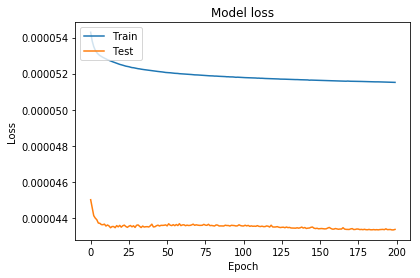

In [222]:
import matplotlib.pyplot as plt


# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [223]:
weights, biases = model.layers[0].get_weights()


In [224]:
# #list(biases)
# model.save('sector_model.h5')
# model_0.save('sector_model_0.h5')
# model_1.save('sector_model_1.h5')
# model_2.save('sector_model_2.h5')
# model_3.save('sector_model_3.h5')
# model_4.save('sector_model_4.h5')
# model_5.save('sector_model_5.h5')
# model_6.save('sector_model_6.h5')
# model_7.save('sector_model_7.h5')
# model_8.save('sector_model_8.h5')
# model_9.save('sector_model_9.h5')

#dataset = raw_dataset.copy()
#dataset = from_network('SPY').sort_values(by=['Date'],ascending=False)
# add function to cache fetch
QQQ = from_network('QQQ').sort_values(by=['Date'],ascending=False)
SPY = from_network('SPY').sort_values(by=['Date'],ascending=False)
XLK = from_network('XLK').sort_values(by=['Date'],ascending=False)
XLF = from_network('XLF').sort_values(by=['Date'],ascending=False)
XLE = from_network('XLE').sort_values(by=['Date'],ascending=False)
XLP = from_network('XLP').sort_values(by=['Date'],ascending=False)
XLV = from_network('XLV').sort_values(by=['Date'],ascending=False)
XLY = from_network('XLY').sort_values(by=['Date'],ascending=False)
XLI = from_network('XLI').sort_values(by=['Date'],ascending=False)
XLU = from_network('XLU').sort_values(by=['Date'],ascending=False)

#dataset = pd.concat([QQQ,SPY,XLK,XLF,XLE,XLP,XLV,XLY,XLI,XLU]).sort_values(by=['Date'],ascending=False)



In [225]:
securities_to_predict = [
    ['SPY', np.array(convert_to_train(SPY.copy(), 0)[0][:1])],
    ['QQQ', np.array(convert_to_train(QQQ.copy(), 0)[0][:1])],
    ['XLE', np.array(convert_to_train(XLE.copy(), 0)[0][:1])],
    ['XLF', np.array(convert_to_train(XLF.copy(), 0)[0][:1])],
    ['XLK', np.array(convert_to_train(XLK.copy(), 0)[0][:1])],
    ['XLP', np.array(convert_to_train(XLP.copy(), 0)[0][:1])],
    ['XLV', np.array(convert_to_train(XLV.copy(), 0)[0][:1])],
    ['XLU', np.array(convert_to_train(XLU.copy(), 0)[0][:1])],
    ['XLY', np.array(convert_to_train(XLY.copy(), 0)[0][:1])],
    ['XLI', np.array(convert_to_train(XLI.copy(), 0)[0][:1])],
]


In [226]:
# SPY.copy()
# securities_to_predict
# model = load_model('sector_model.h5')
# model_0 = load_model('sector_model_0.h5')
# model_1 = load_model('sector_model_1.h5')
# model_2 = load_model('sector_model_2.h5')
# model_3 = load_model('sector_model_3.h5')
# model_4 = load_model('sector_model_4.h5')
# model_5 = load_model('sector_model_5.h5')
# model_6 = load_model('sector_model_6.h5')
# model_7 = load_model('sector_model_7.h5')
# model_8 = load_model('sector_model_8.h5')
# model_9 = load_model('sector_model_9.h5')


In [227]:
def print_arg(arr):
    print '{} {}'.format(arr[0],str(arr[1]))
    
    

def generate_model_predictions(model):

    predictions = map(lambda arr: [arr[0], model.predict(arr[1])], securities_to_predict)
    predictions.sort(key=lambda x: x[1],reverse=True)
#     print map(print_arg, predictions)
    print map(lambda arr: arr[0],predictions)



#print map(lambda arr: str(arr[0]+''+str(arr[1])+'\\n'),predictions)
#print predictions



In [228]:
map(generate_model_predictions,[model, model_1, model_2, model_3, model_4,model_5,model_6,model_7,model_8,model_9,model_0])


['XLK', 'XLI', 'QQQ', 'XLY', 'SPY', 'XLV', 'XLE', 'XLP', 'XLU', 'XLF']
['XLY', 'XLI', 'QQQ', 'SPY', 'XLP', 'XLK', 'XLE', 'XLF', 'XLV', 'XLU']
['XLP', 'XLU', 'XLV', 'XLI', 'SPY', 'XLF', 'XLY', 'QQQ', 'XLK', 'XLE']
['XLF', 'XLE', 'XLY', 'XLU', 'XLI', 'XLV', 'SPY', 'XLP', 'QQQ', 'XLK']
['XLE', 'XLV', 'XLP', 'XLY', 'SPY', 'XLF', 'XLI', 'XLU', 'QQQ', 'XLK']
['XLI', 'XLK', 'QQQ', 'XLP', 'SPY', 'XLY', 'XLU', 'XLF', 'XLV', 'XLE']
['XLP', 'XLV', 'XLI', 'XLU', 'QQQ', 'SPY', 'XLK', 'XLY', 'XLE', 'XLF']
['XLV', 'XLP', 'XLU', 'XLE', 'XLF', 'XLI', 'XLY', 'SPY', 'XLK', 'QQQ']
['XLP', 'XLF', 'XLI', 'XLY', 'XLU', 'SPY', 'XLV', 'XLE', 'QQQ', 'XLK']
['XLK', 'XLV', 'QQQ', 'XLE', 'XLP', 'SPY', 'XLU', 'XLY', 'XLI', 'XLF']
['XLU', 'XLI', 'XLK', 'XLF', 'XLP', 'SPY', 'XLY', 'QQQ', 'XLE', 'XLV']


[None, None, None, None, None, None, None, None, None, None, None]

In [229]:
['XLK', 'XLI', 'QQQ', 'XLY', 'SPY', 'XLV', 'XLE', 'XLP', 'XLU', 'XLF']
['XLY', 'XLI', 'QQQ', 'SPY', 'XLP', 'XLK', 'XLE', 'XLF', 'XLV', 'XLU']
['XLP', 'XLU', 'XLV', 'XLI', 'SPY', 'XLF', 'XLY', 'QQQ', 'XLK', 'XLE']
['XLF', 'XLE', 'XLY', 'XLU', 'XLI', 'XLV', 'SPY', 'XLP', 'QQQ', 'XLK']
['XLE', 'XLV', 'XLP', 'XLY', 'SPY', 'XLF', 'XLI', 'XLU', 'QQQ', 'XLK']
['XLI', 'XLK', 'QQQ', 'XLP', 'SPY', 'XLY', 'XLU', 'XLF', 'XLV', 'XLE']
['XLP', 'XLV', 'XLI', 'XLU', 'QQQ', 'SPY', 'XLK', 'XLY', 'XLE', 'XLF']
['XLV', 'XLP', 'XLU', 'XLE', 'XLF', 'XLI', 'XLY', 'SPY', 'XLK', 'QQQ']
['XLP', 'XLF', 'XLI', 'XLY', 'XLU', 'SPY', 'XLV', 'XLE', 'QQQ', 'XLK']
['XLV', 'XLU', 'XLE', 'XLF', 'SPY', 'XLP', 'XLY', 'QQQ', 'XLK', 'XLI']
['XLU', 'XLI', 'XLK', 'XLF', 'XLP', 'SPY', 'XLY', 'QQQ', 'XLE', 'XLV']

['XLU', 'XLI', 'XLK', 'XLF', 'XLP', 'SPY', 'XLY', 'QQQ', 'XLE', 'XLV']

In [230]:
['XLE', 'XLK', 'XLU', 'XLV', 'XLP', 'XLF', 'XLI', 'XLY', 'SPY', 'QQQ']
['XLI', 'XLY', 'XLF', 'QQQ', 'XLV', 'XLP', 'XLE', 'XLU', 'SPY', 'XLK']
['QQQ', 'XLE', 'XLV', 'SPY', 'XLY', 'XLP', 'XLI', 'XLU', 'XLF', 'XLK']
['XLV', 'XLE', 'XLI', 'XLY', 'XLF', 'XLK', 'XLU', 'XLP', 'QQQ', 'SPY']
['QQQ', 'XLE', 'XLV', 'XLP', 'XLI', 'XLY', 'SPY', 'XLU', 'XLK', 'XLF']
['XLE', 'QQQ', 'XLP', 'XLF', 'XLI', 'XLU', 'SPY', 'XLY', 'XLV', 'XLK']
['XLI', 'XLP', 'XLK', 'XLY', 'XLF', 'XLV', 'XLE', 'SPY', 'XLU', 'QQQ']
['XLU', 'XLE', 'XLP', 'SPY', 'XLY', 'QQQ', 'XLI', 'XLF', 'XLV', 'XLK']
['XLK', 'XLV', 'XLF', 'XLY', 'XLE', 'XLI', 'XLP', 'XLU', 'SPY', 'QQQ']
['XLP', 'SPY', 'XLF', 'XLE', 'XLU', 'XLI', 'QQQ', 'XLY', 'XLV', 'XLK']
['XLF', 'XLP', 'XLK', 'XLE', 'XLY', 'QQQ', 'XLV', 'XLI', 'SPY', 'XLU']

['XLF', 'XLP', 'XLK', 'XLE', 'XLY', 'QQQ', 'XLV', 'XLI', 'SPY', 'XLU']